# ⚛️ H₂ QSE — Quantum Subspace Expansion (Noiseless)

Implements **Quantum Subspace Expansion (QSE)** for H₂ using the package API.

Workflow:
1) Run (or load cached) noiseless VQE to obtain the reference state |ψ⟩
2) Build an operator pool (Hamiltonian top-|coeff| Pauli terms + identity)
3) Form subspace matrices:
      H_ij = ⟨ψ| O_i† H O_j |ψ⟩
      S_ij = ⟨ψ| O_i†   O_j |ψ⟩
4) Solve the generalized EVP: H c = E S c

Output:
- lowest-k QSE eigenvalues (approx ground + excited energies in the expanded subspace)

## 🔧 Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import qchem

from vqe import run_qse
from common.plotting import build_filename, save_plot

## Configuration

In [11]:
molecule = "H2"
seed = 0
mapping = "jordan_wigner"

# VQE reference controls (QSE uses the VQE statevector internally)
ansatz_name = "UCCSD"
optimizer_name = "Adam"
steps = 50
stepsize = 0.2

# QSE controls
k = 4
pool = "hamiltonian_topk"
max_ops = 24
eps = 1e-8

# Cache control
force = False

print("Molecule:", molecule)
print("Seed:", seed)
print("Mapping:", mapping)
print("VQE ref:", {"ansatz": ansatz_name, "optimizer": optimizer_name, "steps": steps, "stepsize": stepsize})
print("QSE:", {"k": k, "pool": pool, "max_ops": max_ops, "eps": eps})
print("Force recompute:", force)

Molecule: H2
Seed: 0
Mapping: jordan_wigner
VQE ref: {'ansatz': 'UCCSD', 'optimizer': 'Adam', 'steps': 50, 'stepsize': 0.2}
QSE: {'k': 4, 'pool': 'hamiltonian_topk', 'max_ops': 24, 'eps': 1e-08}
Force recompute: False


## Part 1 — Run QSE (Package API)

In [12]:
res = run_qse(
    molecule=str(molecule),
    k=int(k),
    ansatz_name=str(ansatz_name),
    optimizer_name=str(optimizer_name),
    steps=int(steps),
    stepsize=float(stepsize),
    seed=int(seed),
    mapping=str(mapping),
    pool=str(pool),
    max_ops=int(max_ops),
    eps=float(eps),
    force=bool(force),
)

if "eigenvalues" not in res:
    raise KeyError("run_qse result missing key 'eigenvalues'")

e_qse = np.array(res["eigenvalues"], dtype=float)

if e_qse.size == 0:
    raise RuntimeError("run_qse returned no eigenvalues")

QSE pool build: kept 15 ops, skipped 1 of 15 terms


## Part 2 — Print lowest-k QSE energies

In [13]:
print("\nH₂ QSE — Lowest-k eigenvalues (Ha)\n")

header = f"{'Level':>7}  {'E_QSE (Ha)':>14}"
print(header)
print("-" * len(header))

for i, e in enumerate(list(e_qse)):
    print(f"{i:7d}  {float(e):14.10f}")


H₂ QSE — Lowest-k eigenvalues (Ha)

  Level      E_QSE (Ha)
-----------------------
      0   -1.1372701749
      1   -0.5324790142
      2   -0.1699013989
      3    0.4798361027


## Part 3 — Reference: exact qubit spectrum (same Hamiltonian)

Diagonalize the qubit Hamiltonian directly (small-H₂ sanity check).

In [14]:
def exact_spectrum_h2(*, mapping: str, basis: str = "sto-3g"):
    # Registry-style H2 geometry (Å)
    symbols = ["H", "H"]
    coordinates = np.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.7414]], dtype=float)

    H, n_wires = qchem.molecular_hamiltonian(
        symbols,
        coordinates,
        basis=str(basis),
        unit="Angstrom",
        mapping=str(mapping),
    )

    Hmat = np.array(qml.matrix(H), dtype=complex)
    evals = np.sort(np.linalg.eigvalsh(Hmat))
    return evals, int(n_wires), str(basis)

e_exact, n_wires, basis = exact_spectrum_h2(mapping=mapping)

print(f"Molecule: {molecule}")
print(f"Qubits:   {n_wires}")
print(f"Basis:    {basis}")
print("Lowest 10 exact eigenvalues (Ha):")
for i, e in enumerate(list(e_exact[:10])):
    print(f"#{i:>2}: {float(e): .10f}")

Molecule: H2
Qubits:   4
Basis:    sto-3g
Lowest 10 exact eigenvalues (Ha):
# 0: -1.1372701749
# 1: -0.5387095807
# 2: -0.5387095807
# 3: -0.5324790143
# 4: -0.5324790143
# 5: -0.5324790143
# 6: -0.4469857253
# 7: -0.4469857253
# 8: -0.1699013991
# 9:  0.2378052722


## Part 4 — Diagnostics (overlap filtering)

QSE solves H c = E S c after filtering near-singular directions in S.

In [15]:
diag = dict(res.get("diagnostics", {}))

print("\nQSE diagnostics\n")
print(f"Subspace dim:     {diag.get('subspace_dim', 'N/A')}")
print(f"Kept rank:        {diag.get('kept_rank', 'N/A')}")
print(f"eps cutoff:       {diag.get('eps', 'N/A')}")
print(f"S eig min kept:   {diag.get('S_eig_min_kept', 'N/A')}")
print(f"S eig max kept:   {diag.get('S_eig_max_kept', 'N/A')}")
print(f"S cond (kept):    {diag.get('S_condition_kept', 'N/A')}")

s_eigs = diag.get("S_eigs", None)
if s_eigs is not None:
    s_list = [float(x) for x in list(s_eigs)]
    print("\nS eigenvalues (all):")
    for j, v in enumerate(s_list):
        print(f"  {j:3d}: {float(v):+.6e}")


QSE diagnostics

Subspace dim:     15
Kept rank:        4
eps cutoff:       1e-08
S eig min kept:   1.0813271608617177e-06
S eig max kept:   10.99999702648712
S cond (kept):    10172681.705064302

S eigenvalues (all):
    0: -1.923533e-15
    1: -6.139402e-16
    2: -1.960689e-16
    3: -1.062799e-16
    4: -3.513728e-17
    5: -9.177913e-18
    6: -2.311848e-25
    7: +4.332881e-30
    8: +2.312180e-25
    9: +2.305248e-16
   10: +2.118501e-15
   11: +1.081327e-06
   12: +1.950060e-06
   13: +4.000000e+00
   14: +1.100000e+01


## Part 5 — Match QSE levels to nearest exact energies (one-to-one)

The QSE subspace does not guarantee the returned levels align with the first-k
exact eigenpairs (especially if the pool is small). We do a simple one-to-one
nearest-energy matching against the low-energy part of the exact spectrum.

In [16]:
def greedy_nearest_one_to_one(e_pred, e_cand):
    e_pred = np.array(e_pred, dtype=float)
    e_cand = np.array(e_cand, dtype=float)

    used = set()
    match = []

    for i, ep in enumerate(list(e_pred)):
        diffs = np.abs(e_cand - ep)
        order = np.argsort(diffs)

        j_best = None
        for j in order:
            jj = int(j)
            if jj not in used:
                j_best = jj
                break

        if j_best is None:
            j_best = int(order[0])

        used.add(j_best)
        match.append(j_best)

    return np.array(match, dtype=int)

N_exact = 20
cand = np.array(e_exact[:N_exact], dtype=float)

match_idx = greedy_nearest_one_to_one(e_qse, cand)
e_match = cand[match_idx]

## Part 6 — Plot: QSE vs matched exact levels

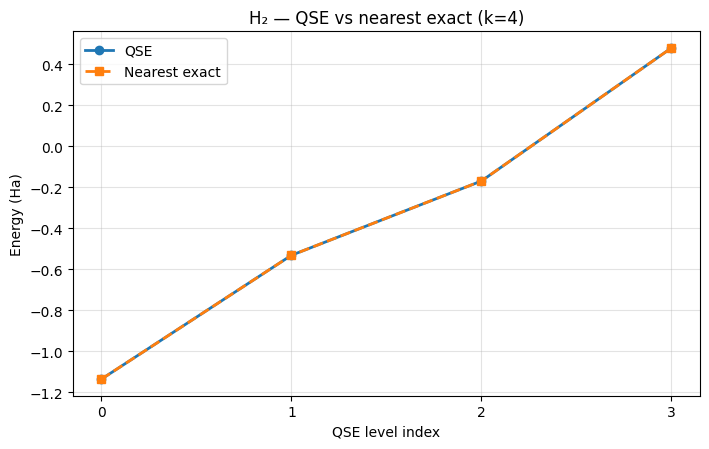

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/qse_vs_exact_UCCSD_Adam_jordan_wigner_s0.png


'/workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/qse_vs_exact_UCCSD_Adam_jordan_wigner_s0.png'

In [17]:
x = np.arange(e_qse.size)

plt.figure(figsize=(7.2, 4.6))
plt.plot(x, e_qse, "-o", label="QSE", linewidth=2)
plt.plot(x, e_match, "--s", label="Nearest exact", linewidth=2)

for i in range(int(x.size)):
    plt.plot(
        [x[i], x[i]],
        [e_qse[i], e_match[i]],
        linestyle=":",
        linewidth=1,
        alpha=0.6,
        color="gray",
    )

plt.xticks(x, [f"{i}" for i in x])
plt.xlabel("QSE level index")
plt.ylabel("Energy (Ha)")
plt.title(f"H₂ — QSE vs nearest exact (k={int(e_qse.size)})")
plt.grid(True, alpha=0.35)
plt.legend()
plt.tight_layout()

fname = build_filename(
    topic="qse_vs_exact",
    ansatz=ansatz_name,
    optimizer=optimizer_name,
    mapping=mapping,
    seed=seed,
)

save_plot(
    fname,
    kind="vqe",
    molecule=molecule,
    show=True,
)

## Part 7 — Match table (QSE → exact)

In [18]:
print("\nMatch table (QSE -> exact):\n")
for i, j in enumerate(list(match_idx)):
    dq = float(e_qse[i] - e_match[i])
    print(
        f"QSE {i:2d}: {float(e_qse[i]): .10f}  ->  "
        f"Exact idx {int(j):2d}: {float(e_match[i]): .10f}  "
        f"(Δ={dq:+.3e})"
    )


Match table (QSE -> exact):

QSE  0: -1.1372701749  ->  Exact idx  0: -1.1372701749  (Δ=+6.661e-16)
QSE  1: -0.5324790142  ->  Exact idx  5: -0.5324790143  (Δ=+8.838e-11)
QSE  2: -0.1699013989  ->  Exact idx  8: -0.1699013991  (Δ=+1.567e-10)
QSE  3:  0.4798361027  ->  Exact idx 13:  0.4798361027  (Δ=+1.665e-16)
